In [1]:
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
import torch.distributions as D
import math
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import matplotlib
from typing import List, Tuple, Dict

matplotlib.rcParams['animation.writer'] = 'ffmpeg'  # conda install ffmpeg

In [2]:
# https://arxiv.org/pdf/1505.05770.pdf
# https://github.com/e-hulten/planar-flows/tree/bbbba2b143873b21224066af69e46a059914cbf2
# https://github.com/acids-ircam/pytorch_flows/blob/master/flows_02.ipynb
# https://towardsdatascience.com/variational-inference-with-normalizing-flows-on-mnist-9258bbcf8810

# although we have to ensure invertibility, otherwise the determant could be zero!, 
# these kind of flows are not designed to be inverted like in the "Glow" paper,
# instead they are used to forward transform a sample ie. u ~ N(0, 1)
# into x ~ px(x) with log px(x) = log pu(u) - sum(of all "logdet" in forward)
# x = model(u) 

logabs = lambda x: torch.log(torch.abs(x) + 1e-5)


class PlanarFlowBlock(nn.Module):
    
    def __init__(self, in_channels) -> None:
        super().__init__()
        
        self.w = nn.Parameter(torch.randn(1, in_channels).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1, 1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, in_channels).normal_(0, 0.1))
        
        # self.reset_parameters(in_channels)
        self.in_channels = in_channels
        
    def reset_parameters(self, dim):
        init.uniform_(self.w, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.u, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.b, -math.sqrt(1/dim), math.sqrt(1/dim))
    
    def u_hat(self, wtu):
        self.u.data = self.u + (-1 + torch.log(1 + torch.exp(wtu)) - wtu) * self.w / (self.w @ self.w.T) 
        
    def forward(self, x):
        
        with torch.no_grad():  # ensure invertibility
            wtu = self.u @ self.w.T
            if wtu < -1:  # invertibility condition not satisfied
                self.u_hat(wtu)
        
        y = x + self.u * torch.tanh(x @ self.w.T + self.b)
        
        psi = (1 - torch.tanh(x @ self.w.T + self.b)**2) * self.w
        logdet = logabs(1 + psi @ self.u.T)
        
        return y, logdet


class RadialFlowBlock(nn.Module):
    
    def __init__(self, in_channels) -> None:
        super().__init__()
        
        self.z0 = Parameter(torch.randn(1, in_channels).normal_(0, 0.1))
        self.log_alpha = Parameter(torch.randn(1, 1).normal_(0, 0.1))
        self.beta = Parameter(torch.randn(1, 1).normal_(0, 0.1))
        
        # self.reset_parameters(in_channels)
        self.in_channels = in_channels
        
    def reset_parameters(self, dim):
        init.uniform_(self.z0, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.log_alpha, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.beta, -math.sqrt(1/dim), math.sqrt(1/dim))
    
    def beta_hat(self, alpha):
        self.beta.data = -alpha + torch.log(1 + torch.exp(self.beta))
        
    def forward(self, x):
        
        alpha = torch.exp(self.log_alpha)
        
        with torch.no_grad():  # ensure invertibility
            if self.beta < -alpha:  # invertibility condition not satisfied
                self.beta_hat(alpha)
            
        diff = x - self.z0
        r = torch.norm(diff, p=2, dim=1, keepdim=True)
        beta_h = self.beta / (alpha + r)
        beta_dh = -self.beta / (alpha + r)**2
        
        y = x + beta_h * diff
        
        logdet = logabs( (1 + beta_h)**(self.in_channels-1) * (1 + beta_h + beta_dh * r) )
        
        return y, logdet

In [12]:
class Flow(nn.Module):
    
    def __init__(self, flows: nn.ModuleList):
        super().__init__()
        self.flows = flows
        self.in_channels = flows[0].in_channels
        self.prior = D.Normal(torch.zeros(self.in_channels), torch.ones(self.in_channels))  # N(0, 1)

    def forward(self, mu ,std):
        batch_size = mu.shape[0]
        samples = self.prior.sample(sample_shape=(batch_size,))
        z0 = samples * std + mu
        zk = z0
        # https://www.ritchievink.com/blog/2019/10/11/sculpting-distributions-with-normalizing-flows/
        sumlogdet = 0.0
        for flowblock in self.flows:  # zk = fk( ... f1(z0))
            zk, logdet = flowblock(zk)
            sumlogdet = sumlogdet + logdet

        zK = zk
        return zK, z0, sumlogdet

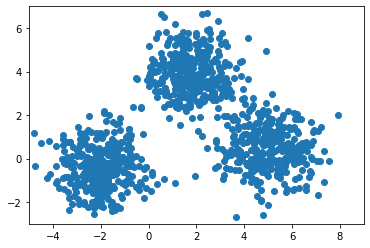

In [4]:
mix = D.Categorical(torch.ones(3,))
loc = torch.tensor([[5.0, 0.5],[1.8, 3.9],[-2.0, -0.5]])
comp = D.Independent(D.Normal(loc, torch.ones(3,2)), 1)
gmm = D.MixtureSameFamily(mix, comp)

sample = gmm.sample(sample_shape=(1000,))
plt.scatter(*sample.T)
plt.gca().set_xlim(-5, 9)
plt.gca().set_ylim(-3, 7)
plt.show()

In [5]:
class FCNEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, dim_output: int):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.net.append(nn.Tanh())
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            
        self.net = nn.Sequential(*self.net)
        self.mu, self.log_std = nn.Linear(hidden_sizes[-1], dim_output), nn.Linear(hidden_sizes[-1], dim_output)

    def forward(self, x):
        x = self.net(x)
        return self.mu(x), torch.exp(self.log_std(x))

In [6]:

class FCNDecoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.net.append(nn.Tanh())
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        self.net = nn.Sequential(*self.net)

    def forward(self, z: torch.Tensor):
        return self.net(z)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_parameters(model):
    print(model.__class__.__name__, count_parameters(model))

def generate(flow, decoder, shape: Tuple[int]):
    zk, *_ = flow(torch.zeros(shape), torch.ones(shape))
    x_hat = decoder(zk)
    return x_hat

In [8]:
def plot_losses(losses: Dict[str, List[float]]):
    for k, v in losses.items():
        fig = plt.figure()
        plt.ylabel(k)
        plt.xlabel('steps')
        plt.plot(v)
        plt.show()
        plt.close()   

In [9]:
def kl_divergence(z0, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z0)
    log_pz = p.log_prob(z0)

    # kl
    kl = log_qzx - log_pz
    kl = kl.sum(-1)
    return kl

Flow 2580
FCNEncoder 12804
FCNDecoder 8834


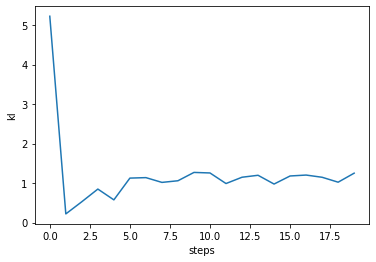

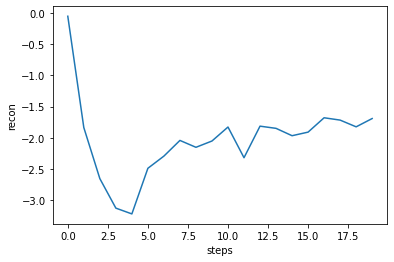

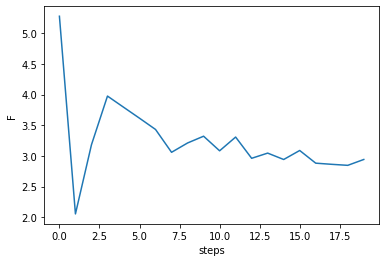

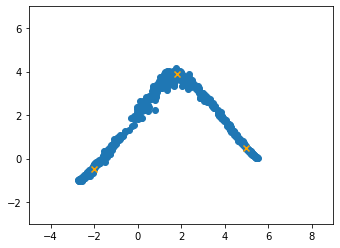

In [16]:
in_channels = 2
latent_channels = 64
hidden_channels = 64
batch_size = 128
num_steps = 1000
log_every_nth = 50
lr = 5e-3
n_points = 500
num_flows = 20
beta = 0.01
annealing_steps = num_steps // 8
beta_scheduler = lambda step: min(1.0, 0.01 + step / annealing_steps)

# flows = nn.ModuleList([RadialFlowBlock(latent_channels) for _ in range(num_flows)])
flows = nn.ModuleList([PlanarFlowBlock(latent_channels) for _ in range(num_flows)])
flow = Flow(flows)
print_parameters(flow)

encoder = FCNEncoder([hidden_channels, hidden_channels], in_channels,  latent_channels)
print_parameters(encoder)

decoder = FCNDecoder([hidden_channels, hidden_channels, in_channels], latent_channels)
print_parameters(decoder)

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

frames = []
losses = {'kl': [], 'recon': [], 'F': []}
for step in range(num_steps):
    x = gmm.sample(sample_shape=(batch_size,))
    mu, std = encoder(x)
    zK, z0, sumlogdet = flow(mu, std)
    x_hat = decoder(zK)
    p = D.Normal(x_hat, torch.ones(in_channels))
    
    beta = beta_scheduler(step)
    # see https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    recon = beta * torch.clamp(p.log_prob(x), -100).mean()
    
    kl = kl_divergence(z0, mu, std).mean()
    
    # ELBO = -F, therfore maximizing ELBO <=> minimizing F (aka. free energy)
    optimizer.zero_grad(set_to_none=True)
    F = kl - recon
    F.backward()
    optimizer.step()
    
    if step % log_every_nth == 0:
        with torch.no_grad():
            losses['kl'].append(kl.item())
            losses['recon'].append(recon.item())
            losses['F'].append(F.item())
            frames.append(generate(flow, decoder, (n_points, latent_channels)))

plot_losses(losses)

with torch.no_grad():
    x_hat = generate(flow, decoder, (n_points, latent_channels))
    ax = plt.gca()
    ax.set_xlim(-5, 9)
    ax.set_ylim(-3, 7)
    ax.set_aspect ('equal')
    ax.scatter(*x_hat.detach().numpy().T)
    ax.scatter(*loc.T, marker='x', c='orange')
    plt.show()
    
    
# TODO:
# https://arxiv.org/pdf/1604.04960.pdf
# https://arxiv.org/pdf/1511.05644.pdf

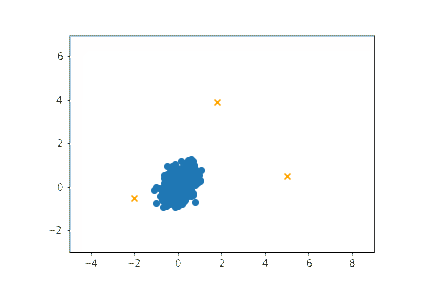

In [17]:
def AnimationFunction(frame):
    ax = plt.gca()
    ax.clear()
    ax.set_xlim(-5, 9)
    ax.set_ylim(-3, 7)
    ax.set_aspect ('equal')
    ax.scatter(*frame.detach().numpy().T)
    ax.scatter(*loc.T, marker='x', c='orange')


anim = FuncAnimation(plt.gcf(), AnimationFunction, frames=frames, interval=50)
anim.save('animation.gif')
plt.close()
Image(filename='animation.gif')

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde


def plot_density(density, xlim=4, ylim=4, ax=None, cmap="Blues"):
    x = np.linspace(-xlim, xlim, 300)
    y = np.linspace(-ylim, ylim, 300)
    X, Y = np.meshgrid(x, y)
    shape = X.shape
    X_flatten, Y_flatten = np.reshape(X, (-1, 1)), np.reshape(Y, (-1, 1))
    Z = torch.from_numpy(np.concatenate([X_flatten, Y_flatten], 1))
    U = torch.exp(-density(Z))
    U = U.reshape(shape)
    if ax is None:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.set_aspect(1)

    ax.pcolormesh(X, Y, U, cmap=cmap, rasterized=True)
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    return ax


def plot_samples(z):
    nbins = 250
    lim = 4
    # z = np.exp(-z)
    k = gaussian_kde([z[:, 0], z[:, 1]])
    xi, yi = np.mgrid[-lim : lim : nbins * 1j, -lim : lim : nbins * 1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot(111)
    ax.set_xlim(-5, 5)
    ax.set_aspect(1)
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="Blues", rasterized=True)
    return ax


def plot_transformation(model, n=500, xlim=4, ylim=4, ax=None, cmap="Blues"):
    base_distr = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    x = torch.linspace(-xlim, xlim, n)
    xx, yy = torch.meshgrid(x, x)
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=-1).squeeze()

    zk, sum_log_jacobians = model(zz)

    base_log_prob = base_distr.log_prob(zz)
    final_log_prob = base_log_prob - sum_log_jacobians
    qk = torch.exp(final_log_prob)
    if ax is None:
        fig = plt.figure(figsize=[7, 7])
        ax = fig.add_subplot(111)
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.set_aspect(1)
    ax.pcolormesh(
        zk[:, 0].detach().data.reshape(n, n),
        zk[:, 1].detach().data.reshape(n, n),
        qk.detach().data.reshape(n, n),
        cmap=cmap,
        rasterized=True,
    )

    plt.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    if cmap == "Blues":
        ax.set_facecolor(plt.cm.Blues(0.0))
    elif cmap == "Reds":
        ax.set_facecolor(plt.cm.Reds(0.0))

    return ax


def plot_training(model, flow_length, batch_num, lr, axlim):
    ax = plot_transformation(model, xlim=axlim, ylim=axlim)
    ax.text(
        0,
        axlim - 2,
        "Flow length: {}\nDensity of one batch, iteration #{:06d}\nLearning rate: {}".format(
            flow_length, batch_num, lr
        ),
        horizontalalignment="center",
    )
    plt.savefig(
        f"train_plots/iteration_{batch_num:06d}.png",
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.close()


def plot_comparison(model, target_distr, flow_length, dpi=400):
    xlim = ylim = 7 if target_distr == "ring" else 5
    fig, axes = plt.subplots(
        ncols=2, nrows=1, sharex=True, sharey=True, figsize=[10, 5], dpi=dpi
    )
    axes[0].tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    # Plot true density.
    density = TargetDistribution(target_distr)
    plot_density(density, xlim=xlim, ylim=ylim, ax=axes[0])
    axes[0].text(
        0,
        ylim - 1,
        "True density $\exp(-{})$".format(target_distr),
        size=14,
        horizontalalignment="center",
    )

    # Plot estimated density.
    batch = torch.zeros(500, 2).normal_(mean=0, std=1)
    z = model(batch)[0].detach().numpy()
    axes[1] = plot_transformation(model, xlim=xlim, ylim=ylim, ax=axes[1], cmap="Reds")
    axes[1].text(
        0,
        ylim - 1,
        "Estimated density $\exp(-{})$".format(target_distr),
        size=14,
        horizontalalignment="center",
    )
    fig.savefig(
        "results/" + target_distr + "_K" + str(flow_length) + "_comparison.pdf",
        bbox_inches="tight",
        pad_inches=0.1,
    )
    
def plot_available_distributions():
    target_distributions = ["U_1", "U_2", "U_3", "U_4", "ring"]
    cmaps = ["Reds", "Purples", "Oranges", "Greens", "Blues"]
    fig, axes = plt.subplots(1, len(target_distributions), figsize=(20, 5))
    for i, distr in enumerate(target_distributions):
        axlim = 7 if distr == "ring" else 5
        density = TargetDistribution(distr)
        plot_density(density, xlim=axlim, ylim=axlim, ax=axes[i], cmap=cmaps[i])
        axes[i].set_title(f"Name: '{distr}'", size=16)
        plt.setp(axes, xticks=[], yticks=[])
    plt.show()
    
import os
import imageio


def make_gif_from_train_plots(fname: str) -> None:
    png_dir = "train_plots/"
    images = []
    sort = sorted(os.listdir(png_dir))
    for file_name in sort[1::1]:
        if file_name.endswith(".png"):
            file_path = os.path.join(png_dir, file_name)
            images.append(imageio.imread(file_path))

    imageio.mimsave("gifs/" + fname, images, duration=0.05)
    
    
import numpy as np
import torch
from torch import Tensor
from typing import Callable


class TargetDistribution:
    def __init__(self, name: str):
        """Define target distribution. 
        Args:
            name: The name of the target density to use. 
                  Valid choices: ["U_1", "U_2", "U_3", "U_4", "ring"].
        """
        self.func = self.get_target_distribution(name)

    def __call__(self, z: Tensor) -> Tensor:
        return self.func(z)

    @staticmethod
    def get_target_distribution(name: str) -> Callable[[Tensor], Tensor]:
        w1 = lambda z: torch.sin(2 * np.pi * z[:, 0] / 4)
        w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
        w3 = lambda z: 3 * torch.sigmoid((z[:, 0] - 1) / 0.3)

        if name == "U_1":

            def U_1(z):
                u = 0.5 * ((torch.norm(z, 2, dim=1) - 2) / 0.4) ** 2
                u = u - torch.log(
                    torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2)
                    + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2)
                )
                return u

            return U_1
        elif name == "U_2":

            def U_2(z):
                u = 0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2
                return u

            return U_2
        elif name == "U_3":

            def U_3(z):
                u = -torch.log(
                    torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
                    + torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
                    + 1e-6
                )
                return u

            return U_3
        elif name == "U_4":

            def U_4(z):
                u = -torch.log(
                    torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
                    + torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
                    + 1e-6
                )
                return u

            return U_4
        elif name == "ring":

            def ring_density(z):
                exp1 = torch.exp(-0.5 * ((z[:, 0] - 2) / 0.8) ** 2)
                exp2 = torch.exp(-0.5 * ((z[:, 0] + 2) / 0.8) ** 2)
                u = 0.5 * ((torch.norm(z, 2, dim=1) - 4) / 0.4) ** 2
                u = u - torch.log(exp1 + exp2 + 1e-6)
                return u

            return ring_density

In [ ]:
import scipy as sp

class OneByOneConv(nn.Module):
    """
    Invertible 1x1 convolution.
    [Kingma and Dhariwal, 2018.]
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        W, _ = sp.linalg.qr(np.random.randn(dim, dim))
        P, L, U = sp.linalg.lu(W)
        self.P = torch.tensor(P, dtype = torch.float)
        self.L = nn.Parameter(torch.tensor(L, dtype = torch.float))
        self.S = nn.Parameter(torch.tensor(np.diag(U), dtype = torch.float))
        self.U = nn.Parameter(torch.triu(torch.tensor(U, dtype = torch.float),
                              diagonal = 1))
        self.W_inv = None

    def forward(self, x):
        L = torch.tril(self.L, diagonal = -1) + torch.diag(torch.ones(self.dim))
        U = torch.triu(self.U, diagonal = 1)
        z = x @ self.P @ L @ (U + torch.diag(self.S))
        log_det = torch.sum(torch.log(torch.abs(self.S)))
        return z, log_det

    def inverse(self, z):
        if not self.W_inv:
            L = torch.tril(self.L, diagonal = -1) + \
                torch.diag(torch.ones(self.dim))
            U = torch.triu(self.U, diagonal = 1)
            W = self.P @ L @ (U + torch.diag(self.S))
            self.W_inv = torch.inverse(W)
        x = z @ self.W_inv
        log_det = -torch.sum(torch.log(torch.abs(self.S)))
        return x, log_det